In [24]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import json
from tensorflow_addons.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import ast

In [2]:
def history_plot(*args, metric='loss'):
    if len(args) > 1:
        sum_list = []
        for x in args:
            sum_list += x.history[metric]
        val_sum_list = []
        for x in args:
            val_sum_list += x.history['val_' + metric]
        plt.plot(sum_list)
        plt.plot(val_sum_list)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    else:
        history = args[0]
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [3]:
def to_one_hot(x):
    return label_binarize(x, classes=range(149)).flatten()

In [4]:
def id_prep(ser):
    aslists = [json.loads(x) for x in ser.values]
    return np.array([to_one_hot(comp) for comp in aslists])

In [5]:
def get_top_5_ch(array):
    return [champion_index[np.argmax(sub_array)] for sub_array in np.split(array, 5)]

In [6]:
def get_top_5(array):
    return [np.argmax(sub_array) for sub_array in np.split(array, 5)]

In [7]:
def model_eval(test, test_hat):
    test_id = get_top_5(test)
    print('Test composition: '+str(get_top_5_ch(test)))
    print('Predicted composition: '+str(get_top_5_ch(test_hat)))

    error = [np.argwhere(np.sort(sub_array)[::-1] == sub_array[test_id[i]])[0][0] for i, sub_array in enumerate(np.split(test_hat, 5))]
    print('Predicted rank of test champions: '+str(error))

In [11]:
champion_index = list(pd.read_csv('chamion_index.csv', index_col=0).values.flatten())

In [12]:
champion_dict = {y:i for i,y in enumerate(champion_index)}

In [55]:
df = pd.read_csv('high_elo_data/master_EUW_150')

In [56]:
df = pd.concat([df, pd.read_csv('composition_scrape_ids.csv')]).reset_index(drop=True)

In [59]:
df.champions = df.champions.apply(lambda x: ast.literal_eval(x))

In [60]:
df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])

In [61]:
df

,team,id,win,champions,champion_ids
0,blue,4715835086,False,"[Darius, Elise, Zed, Ashe, Morgana]","[20, 25, 144, 8, 76]"
1,red,4715835086,True,"[Viktor, Trundle, Sylas, Jhin, Karma]","[133, 122, 113, 46, 50]"
2,blue,4708370729,False,"[Vladimir, Lee Sin, Orianna, Draven, Janna]","[134, 62, 85, 22, 42]"
3,red,4708370729,True,"[Darius, Rengar, Diana, Karthus, Lulu]","[20, 96, 21, 51, 67]"
4,blue,4705815833,False,"[Aatrox, Morgana, Corki, Karthus, Pyke]","[0, 76, 19, 51, 89]"
...,...,...,...,...,...
55501,red,4384134730,True,"[Garen, Kha'Zix, Cassiopeia, Kog'Maw, Swain]","[33, 57, 17, 60, 112]"
55502,blue,4383893083,True,"[Malphite, Nocturne, Ziggs, Jinx, Lulu]","[69, 82, 145, 47, 67]"
55503,red,4383893083,False,"[Ornn, Diana, Veigar, Ezreal, Nami]","[86, 21, 130, 27, 77]"
55504,blue,4383787921,False,"[Darius, Elise, Yasuo, Lucian, Soraka]","[20, 25, 140, 66, 111]"


In [62]:
df = df.drop_duplicates(subset=['team', 'id', 'win']).copy()

In [63]:
X = np.array([to_one_hot(comp) for comp in df.champion_ids])

In [65]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=100)

In [66]:
X_train.shape

(48871, 745)

In [88]:
encoding_dim = 32
input_comp = tf.keras.layers.Input(shape=(745,))
encoded = tf.keras.layers.Dense(64, activation='relu')(input_comp)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(745, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_comp, decoded)

In [89]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")

In [90]:
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [91]:
tqdm_callback = TQDMProgressBar(show_epoch_progress=False)

In [92]:
history1 = autoencoder.fit(X_train, X_train,
                    epochs=1000,
                    batch_size=64,
                    shuffle=True,
                    verbose=0,
                    validation_data=(X_test, X_test),
                    callbacks=[tqdm_callback])

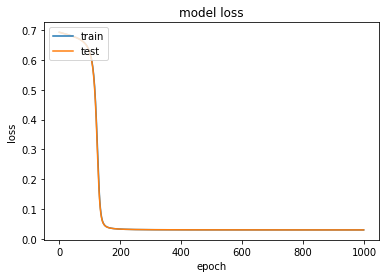

In [93]:
history_plot(history1)

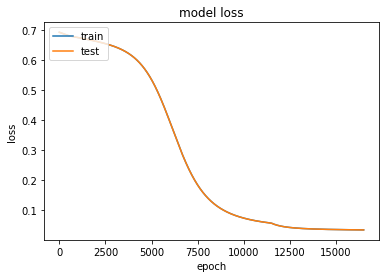

In [206]:
history_plot(history2, history3, history4, history5, history6)

In [84]:
autoencoder.save('saved_models/autoencoder_deep_reg_30000')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/autoencoder_deep_reg_30000/assets


In [141]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 745)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                11936     
_________________________________________________________________
dense_2 (Dense)              (None, 745)               12665     
Total params: 24,601
Trainable params: 24,601
Non-trainable params: 0
_________________________________________________________________


In [94]:
X_test_hat = autoencoder.predict(X_test)

In [161]:
X_test[[0]].shape

(1, 745)

In [95]:
autoencoder.evaluate(X_test,X_test)

170/170 [==============================] - 0s 1ms/step - loss: 0.0306


0.030558962374925613

In [209]:
get_top_5_ch(X_test[0])

['Riven', 'Shaco', 'Talon', "Kai'Sa", 'Bard']

In [233]:
get_top_5_ch(X_test_hat[5])

['Darius', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']

In [227]:
X_test_hat

array([[0.05519509, 0.04484531, 0.03773698, ..., 0.00348708, 0.00343513,
        0.003427  ],
       [0.02656701, 0.00368297, 0.0083043 , ..., 0.00930157, 0.00322044,
        0.00980127],
       [0.0361554 , 0.00582638, 0.01221371, ..., 0.01314345, 0.00531074,
        0.01392817],
       ...,
       [0.03507352, 0.00564334, 0.01211151, ..., 0.01282606, 0.00520396,
        0.014456  ],
       [0.0333769 , 0.00527456, 0.01133767, ..., 0.01141945, 0.00458992,
        0.01276895],
       [0.03167951, 0.0049105 , 0.01036173, ..., 0.0115768 , 0.00441182,
        0.01231733]], dtype=float32)

In [80]:
model_eval(X_test[0], X_test_hat[0])

Test composition: ['Gangplank', 'Vi', 'Lissandra', 'Aphelios', 'Pyke']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [15, 32, 34, 1, 9]


In [102]:
set([str(get_top_5_ch(x)) for x in X_test_hat])

{"['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']"}

In [96]:
for x in range(10):
    print(model_eval(X_test[x], X_test_hat[x]))

Test composition: ['Gangplank', 'Vi', 'Lissandra', 'Aphelios', 'Pyke']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [14, 32, 34, 2, 11]
None
Test composition: ['Poppy', 'Graves', 'Heimerdinger', 'Varus', 'Zyra']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [28, 1, 48, 4, 19]
None
Test composition: ['Garen', 'Jarvan IV', 'Kassadin', "Kai'Sa", 'Lulu']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [16, 8, 10, 1, 2]
None
Test composition: ['Garen', 'Kayn', 'Sylas', 'Miss Fortune', 'Bard']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [16, 7, 12, 3, 1]
None
Test composition: ['Riven', 'Karthus', 'Sylas', 'Aphelios', 'Braum']
Predicted composition: ['Camille', 'Lee Sin', 'Syndra', 'Ezreal', 'Thresh']
Predicted rank of test champions: [11,

In [173]:
get_top_5(X_test[0])

[97, 103, 117, 48, 11]

In [155]:
np.argsort(X_test_hat[0])[::-1]

array([474, 738, 716, 211, 663, 576, 495, 638, 520, 607, 192, 513, 185,
       204, 454, 697, 412,  29, 673, 351, 462, 659, 493, 383, 575, 102,
       221,  75,  20, 432, 442, 322, 436,  16, 174, 455, 494, 675, 319,
       469,   0,  95, 438,  33, 206, 587, 104,  40, 672, 366, 359,  71,
       243, 315,  18, 350,  86, 646, 232, 233, 429,  44,  59, 496, 584,
       249,  34, 688, 230, 299, 328, 685, 173,  35, 568, 271, 231, 368,
       445, 608, 507, 134, 292, 177, 252, 149, 338, 388, 157,  32, 548,
       614, 411,  69, 727, 415, 123, 141, 324, 475, 715, 184, 707, 592,
       168,  97, 356, 336, 742, 708, 262, 396, 140, 422, 367, 245, 284,
       146,  78, 147, 290, 208, 186, 456, 476, 555, 533, 723, 657, 199,
       283, 329, 223,  54, 394,  76, 193, 326,  67, 531, 391, 176, 718,
       468, 120, 248,  30, 107,  90, 195,  49,  85, 167,  88, 373, 710,
       591, 465, 369, 266, 363, 595, 560, 261, 242, 240, 113, 254,   6,
       357, 156, 521, 641, 251, 581, 713, 166, 300, 222, 585, 43